In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

In [2]:
import ephem
from sbpy.data import Ephem
import astropy.units as u
from astropy.time import Time

In [6]:
import sbpy
print('sbpy version ', sbpy.__version__)

import astroquery
print('astroquery version ', astroquery.__version__)

sbpy version  0.2
astroquery version  0.4.2.dev0


In [24]:
# UTC DATE of interest
# (APO = -7 hrs to UTC most of the time .. midnight UTC/start of day is around or before sunset)
date = '2020/10/09 0:00:00'

apo = ephem.Observer()
apo.lat = '32:46:49'
apo.lon = '-105:49:13'
apo.elevation = 2788
# UTC night of interest 
apo.date = date
#civil twilight -6, nautical twilight -12, astronomical twilight -18
apo.pressure = 0   # set pressure to 0 and horizon to -0:34 from desired level, for refraction magic (well .. approximate?)

#apo.horizon = '-18:34'  # astronomical twilight
apo.horizon = '-12:34'  # nautical twilight
#apo.horizon = '-00:34' # civil twilight

sunset = apo.next_setting(ephem.Sun(), use_center=True)
sunrise = apo.next_rising(ephem.Sun(), use_center=True)

In [25]:
# UTC sunset sunrise .. but this seems like it might not be quite right? Close.
print("UTC Sunset ", sunset)
print("Sunset converted to your current local time ", ephem.localtime(sunset))
print("UTC Sunrise ", sunrise)
print("Sunrise converted to your current local time ", ephem.localtime(sunrise))

UTC Sunset  2020/10/9 01:33:57
Sunset converted to your current local time  2020-10-08 18:33:56.894382
UTC Sunrise  2020/10/9 12:07:24
Sunrise converted to your current local time  2020-10-09 05:07:23.704172


In [9]:
# NICFPS: 1024x1024 HgCdTe device with a 0.273 arsec/pixel scale -- 4.58 arcmin across FOV
# ARCTIC: 4096x4096 pixel CCD with an unbinned plate scale of 0.114 arcsec/pixel -- 7.85 arcmin across FOV

In [47]:
# Get target information from Horizons.

targets = ['2020 SV3', '2013 UX14', '2020 SW5', '2020 SO']

# Times here are *like* the date above, but formatted differently.
# And you might want to restrict to a smaller range of times that you're observing the object.

start = Time('2020-10-09T08:00:00')
end = Time('2020-10-09T12:00:00')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ephs = {}
    for t in targets:
        ephs[t] = Ephem.from_horizons(t, location=705, 
                                      epochs={'start': start,
                                              'stop': end,
                                              'step':5*u.min})

In [48]:
ephs[targets[0]].table[0:5]

targetname,H,G,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA*cos(Dec)_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat,epoch
,mag,,,,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,h,,mag,mag,mag / arcsec2,%,arcsec,arcsec,,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,,deg,deg,%,deg,deg,deg,deg,,s,deg,deg,deg,deg,deg,deg,,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,,deg,deg,deg,
str10,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
(2020 SV3),22.407,0.15,,m,26.68366,23.44166,26.9731,23.54495,-101.623,141.9131,209.516158,79.530927,740.65,-372.47,-601711.45,108094.618,327.655,2.1717974277,1.017,0.139,20.875,0.0,98.00516,0.0,574267.0,*,0.0,0.0,0.0,0.0,0.0,35.44,0.0,0.0,0.0,19.6755,2.4353,1.249614960935,-2.2552286,0.26404893609443,-2.7387907,2.19602804,28.176149,9.6808385,159.5186,/L,16.2435,65.9,56.5157,4.243,215.365,233.631,-5.04896,Psc,69.182316,33.4812136,11.6028442,0.0,0.0,139.022346,-37.693841,1.1591109138,0.000354,0.887,0.954,0.957,0.884,-77.446,5.3148213,1.303,39462.5022,0.0035439,56.1,203.91,0.263265,321.2389,0.373590695,16.2391,26.3636,7.0663,2459131.833333333
(2020 SV3),22.407,0.15,,m,26.68109,23.44494,26.97054,23.54824,-101.616,141.8485,214.912301,78.970386,706.86,-433.12,-601730.61,108111.189,327.671,2.2553589244,1.018,0.139,20.875,0.0,98.00544,0.0,574272.5,*,0.0,0.0,0.0,0.0,0.0,35.42,0.0,0.0,0.0,19.678,2.4361,1.249610438439,-2.2551021,0.26404345294714,-2.7297567,2.19598244,28.1762402,9.6752058,159.5201,/L,16.2424,66.0,56.487,4.2426,215.348,233.63,-5.053,Psc,69.182316,33.4801886,11.6067578,0.0,0.0,139.018363,-37.691313,1.2424569898,0.000354,0.888,0.954,0.958,0.885,-77.474,5.3232188,1.304,39461.5353,0.003543,56.09,203.85,0.263259,321.2415,0.457323248,16.2379,26.3643,7.0686,2459131.836805556
(2020 SV3),22.407,0.15,,m,26.67852,23.44822,26.96797,23.55152,-101.605,141.784,219.785173,78.332058,672.59,-484.61,-601749.77,108127.754,327.687,2.3389204212,1.021,0.14,20.875,0.0,98.00572,0.0,574278.0,*,0.0,0.0,0.0,0.0,0.0,35.41,0.0,0.0,0.0,19.6804,2.4368,1.249605916197,-2.2549756,0.26403798789553,-2.7207438,2.19593698,28.1763313,9.6694873,159.5217,/L,16.2412,66.0,56.4585,4.2422,215.331,233.63,-5.05704,Psc,69.182316,33.4791633,11.6106699,0.0,0.0,139.014382,-37.688785,1.3258030828,0.000354,0.889,0.955,0.958,0.885,-77.503,5.3316348,1.305,39460.5687,0.003542,56.07,203.8,0.263253,321.2441,0.541055793,16.2368,26.365,7.0709,2459131.840277778
(2020 SV3),22.407,0.15,,m,26.67596,23.4515,26.9654,23.5548,-101.591,141.7197,224.162716,77.628051,639.16,-527.88,-601768.93,108144.315,327.703,2.4224819178,1.023,0.14,20.875,0.0,98.006,0.0,574283.4,*,0.0,0.0,0.0,0.0,0.0,35.39,0.0,0.0,0.0,19.6829,2.4376,1.249601394209,-2.254849,0.26403254

In [51]:
for t in targets:
    print(t, ephs[t]['elevation'][0])

2020 SV3 79.530927 deg
2013 UX14 45.271802 deg
2020 SW5 50.33484 deg
2020 SO 60.265123 deg


In [52]:
# Narrow down ephemerides to times when the target(s) observable
# Let's cut off at elevation < 10 and Civil twilight, so there's a good buffer.
times = {}
for t in targets:
    ephs[t] = ephs[t][np.where((ephs[t]['elevation'] > 10*u.deg) & (ephs[t]['solar_presence'] != '*'))]
    times[t] = Time(ephs[t]['epoch'], format='mjd', scale='utc')

Text(0, 0.5, 'Elevation')

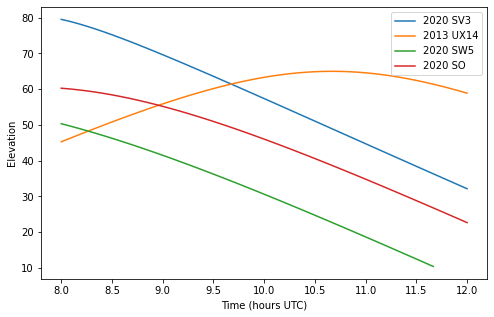

In [70]:
plt.figure(figsize=(8,5))
for t in targets:
    plt.plot((times[t].utc.mjd - int(times[t].utc.mjd[0]))*24.0, 90-ephs[t]['EL'], label=t)
plt.legend()
plt.xlabel('Time (hours UTC)')
plt.ylabel('Elevation')

Text(0, 0.5, 'Elevation')

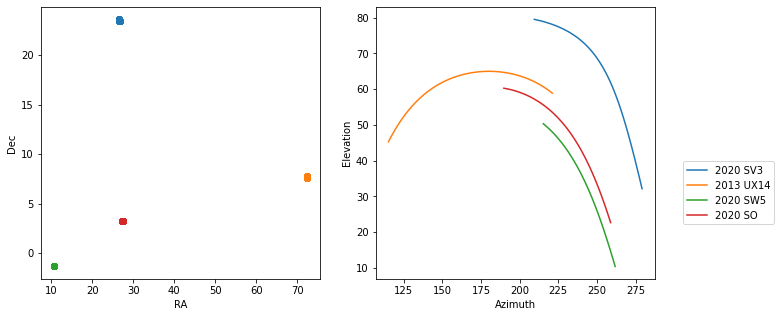

In [86]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
for t in targets:
    plt.plot(ephs[t]['RA'], ephs[t]['DEC'], marker='o', label=t)
#plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.subplot(122)
for t in targets:
    plt.plot(ephs[t]['AZ'], ephs[t]['EL'], label=t)
plt.legend(loc=(1.1, 0.2))
plt.xlabel('Azimuth')
plt.ylabel('Elevation')

In [88]:
for t in targets:
    print(t, " sets at time (UTC) ", times[t].max().isot)

2020 SV3  sets at time (UTC)  2020-10-09T12:00:00.000
2013 UX14  sets at time (UTC)  2020-10-09T12:00:00.000
2020 SW5  sets at time (UTC)  2020-10-09T11:40:00.000
2020 SO  sets at time (UTC)  2020-10-09T12:00:00.000


In [95]:
cols = ['RA', 'DEC', 'RA_3sigma', 'DEC_3sigma', 'V', 'airmass', 'epoch' , 'EL', 'solar_presence', 'lunar_elong']
for t in targets:
    print(ephs[t][cols])

   RA      DEC    RA_3sigma DEC_3sigma ...     EL    solar_presence lunar_elong
  deg      deg      arcsec    arcsec   ...    deg                       deg    
-------- -------- --------- ---------- ... --------- -------------- -----------
26.68366 23.44166     0.887      0.954 ... 79.530927                       65.9
26.68109 23.44494     0.888      0.954 ... 78.970386                       66.0
26.67852 23.44822     0.889      0.955 ... 78.332058                       66.0
26.67596  23.4515      0.89      0.956 ... 77.628051                       66.1
26.67339 23.45478     0.891      0.956 ... 76.869002                       66.1
26.67082 23.45805     0.891      0.957 ... 76.063986                       66.1
26.66826 23.46133     0.892      0.958 ... 75.220601                       66.2
26.66569  23.4646     0.893      0.958 ... 74.345138                       66.2
26.66313 23.46787     0.894      0.959 ...  73.44278                       66.2
26.66056 23.47114     0.894       0.96 .

In [96]:
# TUI commands to slew to target.
for t in targets:
    print(f'Target {t}')
    for i in range(len(ephs[t])):
        print(f"{ephs[t][i]['epoch'].isot} tcc track {ephs[t][i]['RA'].value}, {ephs[t][i]['DEC'].value}, \
        {ephs[t][i]['RA*cos(Dec)_rate'].to(u.deg/u.second).value}, {ephs[t][i]['DEC_rate'].to(u.deg/u.second).value} \
        Fk5=2000.0 /Rotangle=0.0 /Rottype=Object")

Target 2020 SV3
2020-10-09T08:00:00.000 tcc track 26.68366, 23.44166,         -7.841280864197532e-06, 1.095008487654321e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:05:00.000 tcc track 26.68109, 23.44494,         -7.840740740740741e-06, 1.0945100308641975e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:10:00.000 tcc track 26.67852, 23.44822,         -7.839891975308643e-06, 1.0940123456790123e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:15:00.000 tcc track 26.67596, 23.4515,         -7.838811728395062e-06, 1.0935162037037037e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:20:00.000 tcc track 26.67339, 23.45478,         -7.837422839506173e-06, 1.0930216049382715e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:25:00.000 tcc track 26.67082, 23.45805,         -7.835802469135804e-06, 1.0925285493827162e-05         Fk5=2000.0 /Rotangle=0.0 /Rottype=Object
2020-10-09T08:30:00.000 tcc track 26.6